# RTE - Forecast energy consumption in French areas
**Prediction of the energy consumption in French metropolitan areas**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import xgboost as xgb

In [2]:
train = pd.read_csv("../input/rte-forecast-energy-evalml/rte_train_preprocessing.csv")
test = pd.read_csv("../input/rte-forecast-energy-evalml/rte_test_preprocessing.csv")

train.shape, test.shape

((717414, 12), (60870, 11))

In [3]:
train.head()

,metropolitan_area_code,energy_consumption,dateyear,datequarter,datemonth,dateday,dateday_of_week,dateday_of_year,dateweekofyear,datehour,dateminute,dateis_weekend
0,3,477.0,2017,3,9,11,0,254,37,2,15,0
1,3,454.0,2017,3,9,11,0,254,37,2,30,0
2,3,398.0,2017,3,9,11,0,254,37,3,45,0
3,3,398.0,2017,3,9,11,0,254,37,4,45,0
4,3,409.0,2017,3,9,11,0,254,37,5,15,0


In [4]:
train.isna().sum().any(), test.isna().sum().any()

(False, False)

# Split Data

In [5]:
X = train.copy()
y = X.pop("energy_consumption")

In [6]:
from sklearn.model_selection import train_test_split

_, X_test, _, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Modeling : XGBoost

In [7]:
params = {'max_depth': 15, 'n_estimators': 7180, 'random_state': 469, 'learning_rate': 0.6631441798001734, 'objective':'reg:squarederror'}
y_predict = []

In [8]:
model = xgb.XGBRegressor(**params, tree_method='gpu_hist')

model.fit(X, y)

pred = model.predict(X_test)
y_predict.append(model.predict(test))

#model.score(X,y)

In [9]:
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluates_model(y_test, y_pred):
    print("-"*12, "Evaluations : ", "-"*12, '\n')
    
    print("MAE model :", mean_absolute_error(y_test, y_pred))
    
    print("MSE model :", mean_squared_error(y_test, y_pred))
    
    print("R2_Score model :", r2_score(y_test, y_pred))
    
    mse_1 = np.square(np.subtract(y_test,y_pred)).mean() 
    
    print("RMSE model :", math.sqrt(mse_1))

In [10]:
evaluates_model(y_test, pred)

------------ Evaluations :  ------------ 

MAE model : 0.002251233380959723
MSE model : 1.7298926454589016e-05
R2_Score model : 0.999999999986824
RMSE model : 0.004159197813832496


### Features Importance

<AxesSubplot:>

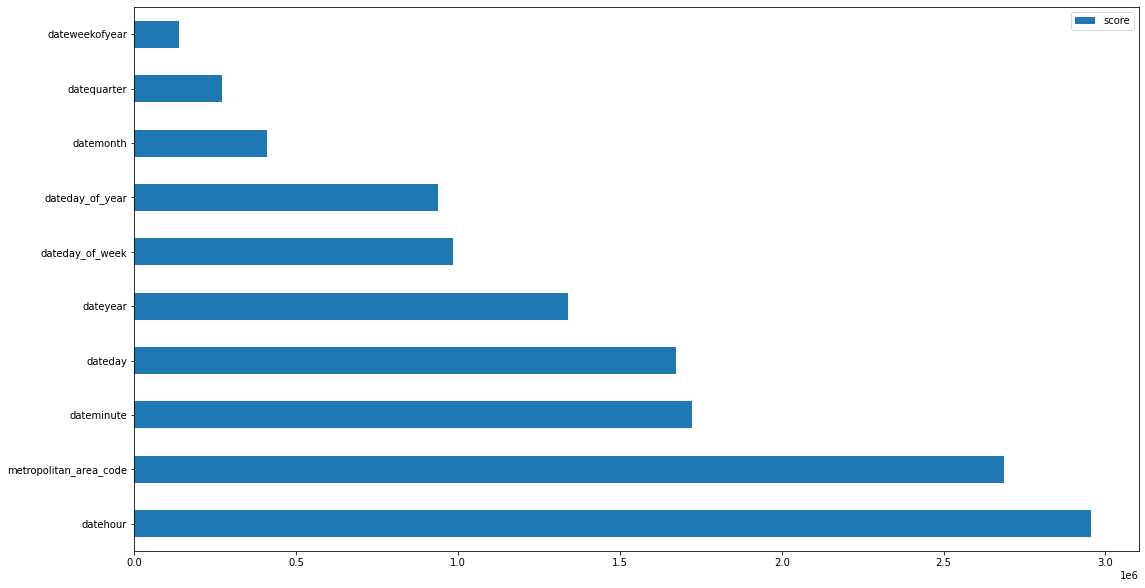

In [11]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(X.shape[1], columns="score").plot(kind='barh', figsize = (18,10)) ## plot top 40 features

# Search Best Params with Optuna

In [12]:
import optuna
#optuna.logging.set_verbosity(optuna.logging.WARNING)

def objectivesXGBReg(trial):
    params = {
        'max_depth' : trial.suggest_int("max_depth", 1, 16),
        'n_estimators': trial.suggest_int('n_estimators', 5, 10000),
        'random_state': trial.suggest_int("random_state", 0, 722),
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1), 
        'tree_method' : 'gpu_hist', 
        'gpu_id': -1
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X,y)

    return model.score(X,y)

#opt = optuna.create_study(direction='maximize')
#opt.optimize(objectivesXGBReg, n_trials=30)

In [13]:
del X_test, y_test, #train
gc.collect()

82

In [14]:
#params = opt.best_params
params 

{'max_depth': 15,
 'n_estimators': 7180,
 'random_state': 469,
 'learning_rate': 0.6631441798001734,
 'objective': 'reg:squarederror'}

# Cross Validation

In [15]:
from sklearn.model_selection import StratifiedKFold

In [16]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 0)

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print('#'*14, f" Fold {fold} ", '#'*14, '\n')
        
        # Split Data
        X_train = X.loc[train_index]
        X_val = X.loc[val_index]

        y_train = y.loc[train_index]
        y_val = y.loc[val_index]
        
        # Create Model here
        model = xgb.XGBRegressor(**params, tree_method='gpu_hist')
        
        # Fit Model
        model.fit(X_train,y_train)

        # Make X_val prediction
        y_pred = model.predict(X_val)
        
        # Make Test prediction
        y_predict.append(model.predict(test))
        
        # Evaluate Model
        print("Training score :", model.score(X_train, y_train))
        evaluates_model(y_val, y_pred)
        print('\n')
        
        # Free the memory
        del X_train, y_train, model, X_val, y_val, y_pred
        gc.collect()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


##############  Fold 0  ############## 

Training score : 0.9999999999892604
------------ Evaluations :  ------------ 

MAE model : 18.852462619395602
MSE model : 1474.548271792102
R2_Score model : 0.9988701869245378
RMSE model : 38.399847288656005


##############  Fold 1  ############## 

Training score : 0.9999999999825964
------------ Evaluations :  ------------ 

MAE model : 18.823280169400984
MSE model : 1460.7799800181951
R2_Score model : 0.9988806617297987
RMSE model : 38.220151491303575


##############  Fold 2  ############## 

Training score : 0.999999999985827
------------ Evaluations :  ------------ 

MAE model : 18.580968424748885
MSE model : 1423.1221488968888
R2_Score model : 0.9989101047982493
RMSE model : 37.72429123120657


##############  Fold 3  ############## 

Training score : 0.9999999999893104
------------ Evaluations :  ------------ 

MAE model : 18.969663734580656
MSE model : 1546.7636630554393
R2_Score model : 0.9988141685620151
RMSE model : 39.3289163727586

# Submission

In [17]:
sub = pd.read_csv("../input/rte-forecast-energy-consumption-in-french-areas/sample_submission.csv")
sub.head()

,id,energy_consumption
0,0,100.01
1,1,100.01
2,2,100.01
3,3,100.01
4,4,100.01


In [18]:
sub['energy_consumption'] = np.array(y_predict).mean(axis=0)
sub

,id,energy_consumption
0,0,772.263672
1,1,782.711243
2,2,781.069153
3,3,772.232483
4,4,783.119629
...,...,...
60865,60865,359.971283
60866,60866,354.142914
60867,60867,384.375519
60868,60868,387.337524


In [19]:
sub.to_csv('submission.csv', index=False)
sub.describe()

,id,energy_consumption
count,60870.00000,60870.000000
mean,30434.50000,950.800171
std,17571.79978,1239.565796
min,0.00000,56.098400
25%,15217.25000,314.277557
50%,30434.50000,473.930191
75%,45651.75000,1021.684570
max,60869.00000,7717.121094
